# Student Information
---

> Dionysios Rigatos <br />
> Department of Informatics  <br />
> Athens University of Economics and Business <br />
> p3200262@aueb.gr

# Exploring Why Civil Resistance Works

In this assignment, you will replicate some of the findings of a well-received book, [Why Civil Resistance Works](https://www.ericachenoweth.com/research/wcrw) by [Erica Chenoweth](https://www.ericachenoweth.com/) and Maria J. Stephan. The two authors examined whether nonviolent campaigns are more effective than violent campaigns. They found that yes; from a data set containing details of campaigns from 1900 onwards, they found that in general peaceful campaigns are more effective in achieving their aims than violent ones.

Following the initial publication of the book in 2011, Erica Chenoweth continued her research on the topic and published a follow-up ten years later, [Civil Resistance: What Everyone Needs to Know](https://www.ericachenoweth.com/research/civil-resistance-what-everyone-needs-to-know). She has also continued to update the data used for her research.

The research became famous for proposing the 3.5% rule: "the claim that no government has withstood a challenge of 3.5% of their population mobilized against it during a peak event"; you can find a nice overview at [Questions, Answers, and Some Cautionary
Updates Regarding the 3.5% Rule](https://carrcenter.hks.harvard.edu/files/cchr/files/CCDP_005.pdf). Among other things, you will investigate that rule.

To answer the questions, you will use that data, the [Nonviolent and Violent Campaigns and Outcomes (NAVCO) Dataset](https://dataverse.harvard.edu/dataverse/navco), and in particular the [NAVCO 1.2 Dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/0UZOTX). You will also use data from the [Polity Project](https://www.systemicpeace.org/polityproject.html), in particular the Polity5 version, available from [Integrated Network for Societal Conflict Research (INSCR) ](https://www.systemicpeace.org/inscrdata.html), in particular the [Polity5 Annual Time-Series, 1946-2018](http://www.systemicpeace.org/inscr/p5v2018.xls).

---

> Panos Louridas, Associate Professor <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> louridas@aueb.gr

## Prologue & Exploratory Data Analysis

* The datasets  re considered to be in a folder named `datasets`, within the same root directory as `wcrw_v2.ipynb`.

* We will use `InlineBackend.figure_format = 'svg'` so as to get high quality plots.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from statsmodels.formula.api import logit
from IPython.display import HTML

%config InlineBackend.figure_format = 'svg'

### Imports

We will be using libraries as shown in the lecture notebooks to ensure compatability.

* `black` was used for automatic formatting, as it is industry standard.

### NAVCO 1.2 Data

We will start with the `NAVCO 1.2` dataset, which contains data consisting of `389 campaigns`, updates the postwar data through 2013 (from `NAVCO 1.1`) and adds new cases that were discovered through additional research. 

* Exceptions to the 3.5% rule were added to the data, such as the `1962 Brunei Revolt` and the `2011 Anti-King Hamad Campaign`, among others.

* The data contains mobilizations in the time range 1945-2013.

In [53]:
navco_df = pd.read_csv(
    "datasets/NAVCO 1.2 Updated.tab",
    delimiter="\t",
    index_col="NAVCOID",
)

navco_df.shape

(862, 24)

* We notice that we have `862` observations and `25` features in our data. 

* The [dataset info page](https://dataverse.harvard.edu/dataverse/navco) claimed `389` campaigns are included in the data, so how could we have `862`?


Let's take a deeper look at our data using `info()`.

* We will see the `dtypes` per column.

* How many `null` or `na` values we have per column.

In [54]:
navco_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 862 entries, 4.0 to nan
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CAMPAIGN                        389 non-null    object 
 1   LOCATION                        389 non-null    object 
 2   BYEAR                           389 non-null    float64
 3   EYEAR                           389 non-null    float64
 4   TARGET                          389 non-null    object 
 5   SUCCESS                         389 non-null    float64
 6   LIMITED                         389 non-null    float64
 7   FAILURE                         389 non-null    float64
 8   ONGOING                         389 non-null    float64
 9   NONVIOL                         389 non-null    float64
 10  VIOL                            389 non-null    float64
 11  REGCHANGE                       389 non-null    float64
 12  FSELFDET                        389 non

* We notice that out of our `862` observations, only `389` seem not to be entirely null. This matches the information given in the dataset's website.

    * We will remove the null rows so as to preserve only relevant information.

    * `PARTICIPATION`, `VIOLENTFLANK` & `VIOLSIM` seem to have some `NaN` values as well, we have to be careful not to drop all `NaN` data points as we will lose relevant observations. We can use the keyword argument `how='all'` so as to ensure we drop rows that are completely null. **We will get back to the why later.**

In [55]:
navco_df.dropna(how="all", inplace=True)
navco_df.shape

(389, 24)

* `BYEAR` and `EYEAR`  seem to be `float` values, despite representing integers.

* This also seems to be the case for other binary values, such as `SUCCESS`, `FAILURE`, `LIMITED`, `VIOL` and `NONVIOL` and so on.

* We can convert them for convenience.

In [56]:
navco_df["BYEAR"] = navco_df["BYEAR"].astype(int)
navco_df["EYEAR"] = navco_df["EYEAR"].astype(int)

navco_df["SUCCESS"] = navco_df["SUCCESS"].astype(int)
navco_df["FAILURE"] = navco_df["FAILURE"].astype(int)
navco_df["LIMITED"] = navco_df["LIMITED"].astype(int)

navco_df["VIOL"] = navco_df["VIOL"].astype(int)
navco_df["NONVIOL"] = navco_df["NONVIOL"].astype(int)

* We seem to be on the right track with `389` observations.

As aforementioned, `PARTICIPATION`, `VIOLENTFLANK` & `VIOLSIM` have null values in certain observations.

* We can take a look at the [NAVCO 1.2 appendix](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/0UZOTX/B4RH7S&version=2.0) as to make some assumptions about these missing values.
    * `Missing Data`: Some of our variables were missing for the observations of interest. This is a common problem when studying cases where conflict is occurring or has occurred, as few people in conflict-affected societies are able to accurately observe and chronicle such figures. Rather than impute these values artificially, we opted to simply accept the missing values.
    

    
* So, lets see the descriptions for each of these attributes so as to make an assumption.
    * `PARTICIPATION` is *"Number of participants observed actively confronting opponent at highest point (peak event). This reports the largest participation reported at a watershed event. It does not estimate the cumulative number of participants."*, which means `NaN` values could be attributed to no reports of participation.

    * `VIOLENTFLANK` is *"Coded for nonviolent campaigns only. Binary variable identifying whether some dissidents within a nonviolent campaign have begun to use violence, even though the larger campaign remains primarily nonviolent, at any point during the course of the campaign."*, so `NaN` values could be attributed to entirely violent campaigns.

    * `VIOLSIM` is *"Binary variable identifying whether a different violent campaign was active simultaneous to the major campaign. Can include an independent terrorist group, violent insurrection, or other violent “spoiler” at any point during the course of the campaign."*,  so `NaN` values could be attributed to missing information.


* Let's now take a look at a sample of our data so we get a general idea.

In [57]:
navco_df.sample(5)

,CAMPAIGN,LOCATION,BYEAR,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,ONGOING,NONVIOL,...,OTHER,DURATION,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,REGVIOL,DEFECT,VIOLENTFLANK,VIOLSIM,REGAID,STATESUP
NAVCOID,,,,,,,,,,,,,,,,,,,,,
165.0,Palestinian activists,Jordan,1970,1970,Jordanian rule,0,0,1,0.0,0,...,1.0,11.0,20000.0,0.013307,1.0,0.0,NaN,1.0,1.0,1.0
272.0,anti-Ravalomanana movement,Madagascar,2009,2009,Ravalomanana government,1,0,0,0.0,1,...,0.0,53.0,30000.0,0.001458,1.0,1.0,0.0,0.0,1.0,0.0
14.0,anti-Doe rebels,Liberia,1989,1990,Doe regime,1,0,0,0.0,0,...,0.0,339.0,3000.0,0.001430,1.0,0.0,NaN,1.0,0.0,0.0
7.0,anti-Arap Moi,Kenya,1990,1991,Daniel Arap Moi,1,0,0,0.0,1,...,0.0,681.0,6000.0,0.000248,1.0,0.0,0.0,0.0,0.0,0.0
230.0,Timorese resistance,East Timor,1989,1999,Indonesian occupation,1,0,0,0.0,1,...,0.0,3640.0,6000.0,0.006950,1.0,1.0,1.0,0.0,0.0,1.0


### Polity5 Project Data

Finally, we will import the `Polity5` dataset, which covers all major, independent states in the global system over the period 1800-2018 to measure authority characteristics of states in the world system for purposes of comparative, quantitative analysis.

* The "Polity Score" captures this `regime authority spectrum` on a `21-point scale` ranging from `-10 (hereditary monarchy)` to `+10 (consolidated democracy)`. The Polity scores can also be converted into regime categories in a suggested three part categorization of "autocracies" (-10 to -6), "anocracies" (-5 to +5 and three special values: -66, -77 and -88), and "democracies" (+6 to +10).



In [58]:
polity5_df = pd.read_excel(
    "datasets/p5v2018.xls",
    index_col=False,
)

polity5_df.shape

(17574, 37)

* We notice that we have `17.574` observations and `37` features in our data. 



Let's take a deeper look at our data using `info()`.

* We will see the `dtypes` per column.

* How many `null` or `na` values we have per column.

In [59]:
polity5_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17574 entries, 0 to 17573
Data columns (total 37 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   p5        17574 non-null  int64  
 1   cyear     17574 non-null  int64  
 2   ccode     17574 non-null  int64  
 3   scode     17574 non-null  object 
 4   country   17574 non-null  object 
 5   year      17574 non-null  int64  
 6   flag      17574 non-null  int64  
 7   fragment  3446 non-null   float64
 8   democ     17574 non-null  int64  
 9   autoc     17574 non-null  int64  
 10  polity    17574 non-null  int64  
 11  polity2   17307 non-null  float64
 12  durable   16310 non-null  float64
 13  xrreg     17574 non-null  int64  
 14  xrcomp    17574 non-null  int64  
 15  xropen    17574 non-null  int64  
 16  xconst    17574 non-null  int64  
 17  parreg    17574 non-null  int64  
 18  parcomp   17574 non-null  int64  
 19  exrec     17391 non-null  float64
 20  exconst   17574 non-null  in

* We notice that some observations have `NaN` values in certain features, however nothing too alarming for now. We will handle them on a need-to-filter basis.

* Finally, we will look at a sample of our data so we get a general idea.

In [60]:
polity5_df.sample(5)

,p5,cyear,ccode,scode,country,year,flag,fragment,democ,autoc,...,interim,bmonth,bday,byear,bprec,post,change,d5,sf,regtrans
11759,0,3271865,327,PAP,Papal States,1865,0,NaN,0,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14718,0,3801825,380,SWD,Sweden,1825,0,NaN,0,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14428,0,2301984,230,SPN,Spain,1984,0,NaN,10,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9895,1,6001826,600,MOR,Morocco,1826,0,NaN,1,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12372,0,2901920,290,POL,Poland,1920,0,NaN,8,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some attributes look odd. Let's use the [P5 Manual](https://www.systemicpeace.org/inscr/p5manualv2018.pdf) for clarification. It will be used throughout the notebook as a reference.

* `cyear` makes no sense at first glance. The description is: *"Country Year: A unique identifier for each country year, consisting of the country code, CCODE, followed by the year. This variable was created to facilitate merging."*.

* Other values need further clarification and will be studied on a need-to-understand basis.

## 1. Exploration of Historical Trends

### Plot #1

Create a plot showing the frequency of nonviolent and violent campaigns; the frequency should be counted based on their end years, at decades. The violent and nonviolent campaign counts should be stacked on each other.

Your plot should look like the following:

<img src="fig_1.svg"/>

For this part, we will make use of the `navco_df` dataframe. Specifically, we need the `VIOL` and `NONVIOL` columns. These columns are supposed to be opposites.

* We can confirm this by taking the `XOR` of their values using `np.logical_xor()` and then ensuring that all the values in the produced boolean dataframe are `True`, using `all()`.

In [61]:
np.logical_xor(navco_df.VIOL, navco_df.NONVIOL).all()

True

Now that we are certain that our values are as expected, let's start preparing the necessary data for the plots.

* First of all, we need to assign each campaign to a decade. We can do this by taking the `EYEAR` column and doing a `div` by 10, then multiplying the result by 10. `div` will return the `floor` value of the result, an integer. For example, for year `1947`, `1947div10` is equal to `194` (unlike `194.7` with normal division). Then, by multiplying by 10, we get the start of the decade that the year belongs to.

* We can then use the decades to perform a `groupby` on our data, and for each `decade`, take the `sum` of the `VIOL` and `NONVIOL` columns by performing an aggregation on the grouped data. Since these two are binary columns, the sum will equal the amount of violent and nonviolent campaigns for that decade.

* Finally, we rename the index column to `DECADE`, as `EYEAR` is no longer representative.

In [62]:
decade = navco_df["EYEAR"] // 10 * 10

nvc_decade_count_df = navco_df.groupby(decade).agg({"NONVIOL": "sum", "VIOL": "sum"})

nvc_decade_count_df.index.name = "DECADE"

nvc_decade_count_df

,NONVIOL,VIOL
DECADE,,
1940,2,12
1950,9,25
1960,8,21
1970,13,27
1980,30,17
1990,36,54
2000,37,23
2010,34,41


Our data looks rad. Let's recreate the plot.

* We can use `seaborn` for the white grid, as the default is gray-ish.

* The `x-axis` shows the `decades`, so we will use the `index` of our dataframe. 

* The `y-axis` shows the amount of `campaigns`, so it's the sum of our columns, `VIOL` & `NONVIOL`.

* We want a stacked chart, so we can use `stackplot()`. Thankfully, we can use the default colours.

* We enable the legend on the upper left side and we adjust the plot `margins()` so as to give the y-axis chart some headroom.

* We take the liberty to do the following:
    * Add a descriptive title.
    * Make the x and y axes more descriptive/clean looking.
    * We swap the colours, giving `darkorange` to `Violent` as it is the more intense, effect wise, colour.

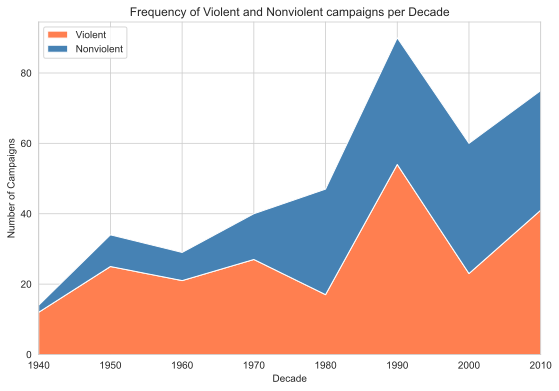

In [63]:
sns.set_style("whitegrid")

plt.figure(figsize=(9, 6))

# Main plot
plt.stackplot(
    nvc_decade_count_df.index,
    nvc_decade_count_df["VIOL"],
    nvc_decade_count_df["NONVIOL"],
    colors=["coral", "steelblue"],
    labels=["Violent", "Nonviolent"],
)

# Details
plt.xlabel("Decade")
plt.ylabel("Number of Campaigns")
plt.title("Frequency of Violent and Nonviolent campaigns per Decade")

plt.legend(loc="upper left")
plt.margins(x=0, y=0.05)

plt.show()

Looks pretty good! So, what do we see?

* The lines follow the same trend.

* More often than not, we have more `VIOL` (violent) campaigns than `NONVIOL`. People seem to be generally unforgiving.

* There is a major jump in the amount of campaigns going from the `80s` to the `90s`. 

---

### Plot #2

Create a plot showing, for each decade from 1940 onwards, the number of nonviolent campaigns and the percentage of success. Your plot will have two vertical axes, one for each of the metrics, and it should look like this:

<img src="fig_2.svg"/>

For this chart, it looks like we will need to do the following;

* Get the amount of `NONVIOL` (nonviolent) campaigns as well as how many of them were successful, so they have `SUCCESS == 1`.

* We can do that by only keeping the rows with `NONVIOL == 1`. 

* We group by decade again, and keep the `sum` of `SUCCESS`'s as well as the `count` of `CAMPAIGN`, which corresponds to the amount of nonviolent campaigns.

In [64]:
nvc_decade_nonviol_success_df = navco_df.loc[navco_df.NONVIOL == 1]

nonviol_decade = nvc_decade_nonviol_success_df["EYEAR"] // 10 * 10

nvc_decade_nonviol_success_df = nvc_decade_nonviol_success_df.groupby(
    nonviol_decade
).agg({"SUCCESS": "sum", "CAMPAIGN": "count"})

nvc_decade_nonviol_success_df

,SUCCESS,CAMPAIGN
EYEAR,,
1940,1,2
1950,2,9
1960,2,8
1970,7,13
1980,14,30
1990,30,36
2000,25,37
2010,13,34


* We then create another column named `SUCCESS_PCT`, which will hold the percentage of successful campaigns by dividing successful nonviolent campaigns with total amount of nonviolent campaigns for a decade.

* Finally, we rename the index column to `DECADE` once again.

In [65]:
nvc_decade_nonviol_success_df["SUCCESS_PCT"] = (
    nvc_decade_nonviol_success_df["SUCCESS"] / nvc_decade_nonviol_success_df["CAMPAIGN"]
)

nvc_decade_nonviol_success_df.index.name = "DECADE"

nvc_decade_nonviol_success_df

,SUCCESS,CAMPAIGN,SUCCESS_PCT
DECADE,,,
1940,1,2,0.500000
1950,2,9,0.222222
1960,2,8,0.250000
1970,7,13,0.538462
1980,14,30,0.466667
1990,30,36,0.833333
2000,25,37,0.675676
2010,13,34,0.382353


Now, to recreate the chart:

* We need a blank background with no gridlines, so once again we will leverage `seaborn`'s `set_style` for this.

* The `x-axis` shows the `decades`, so we will use the `index` of our dataframe. 

* The `y-axis` now holds two variables. One is the amount of campaigns, and one is the successful campaign percentage. We can achieve this by creating two `y-axis`'s and putting them on the same figure.

* We want a twin barplot, we can do this by simply plotting the two `y-axis`'s together on the same figure.

* To create a twin legend, we can use `get_legend_handles_labels()` on both axes. This will return a tuple of lists, which we can concatenate between the same types (labels and lines) to construct the custom double axis for two variables.

* We take the liberty to:
    * Add a title.
    * Add a label on the x-axis.
    * Rename the labels.

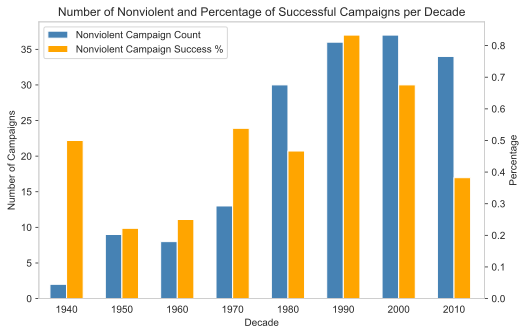

In [66]:
sns.set_style("whitegrid", {"axes.grid": False})

bar_w = 0.3

plt.figure(figsize=(8, 5))

# Main plots
ax_nonviol = nvc_decade_nonviol_success_df.CAMPAIGN.plot(
    kind="bar",
    color="steelblue",
    position=1,
    label="Nonviolent Campaign Count",
    width=bar_w,
)

ax_success_pct = ax_nonviol.twinx()
nvc_decade_nonviol_success_df.SUCCESS_PCT.plot(
    kind="bar",
    color="orange",
    position=0,
    label="Nonviolent Campaign Success %",
    width=bar_w,
    ax=ax_success_pct,
)

ax_nonviol.set_xticklabels(nvc_decade_nonviol_success_df.index, rotation=0)
ax_nonviol.set_xlabel("Decade")
ax_nonviol.set_ylabel("Number of Campaigns")
ax_success_pct.set_ylabel("Percentage")

# Custom double legend
ax_nonviol_lines, ax_nonviol_labels = ax_nonviol.get_legend_handles_labels()
ax_success_pct_lines, ax_success_pct_labels = ax_success_pct.get_legend_handles_labels()

ax_lines = ax_nonviol_lines + ax_success_pct_lines
ax_labels = ax_nonviol_labels + ax_success_pct_labels

ax_nonviol.legend(ax_lines, ax_labels, loc="upper left")

# Plot adjustments
plt.xlim(left=-0.5)
plt.title("Number of Nonviolent and Percentage of Successful Campaigns per Decade")

plt.show()

And we have our plot! What do we see?
* Nonviolent campaigns are a hit-or-miss, depending on the decade, when it comes to having a good success rate.
* The number of campaigns increases through the decades.

---

### Plot #3

Create a plot showing the success rate for violent and nonviolent campaigns by decade. Your plot should look like the following, showing that nonviolent campaigns have higher success probabilities:

<img src="fig_3.svg" />

For the final plot of this task, we still are working with the `navco_df` dataframe. We want to compare the success rates between type of campaigns, specifically between `VIOL` and `NONVIOL` campaigns.

* We are still working with decades, so we should `groupby()` and get, per decade, the amount of campaigns, as well as the amount of violent and nonviolent campaigns in that decade, irregardless of success/failure.

In [67]:
nvc_decade_all_campaign_df = navco_df.groupby(decade).agg(
    {"CAMPAIGN": "count", "VIOL": "sum", "NONVIOL": "sum"}
)
nvc_decade_all_campaign_df

,CAMPAIGN,VIOL,NONVIOL
EYEAR,,,
1940,14,12,2
1950,34,25,9
1960,29,21,8
1970,40,27,13
1980,47,17,30
1990,90,54,36
2000,60,23,37
2010,75,41,34


* Then, we measure the amount of successful campaigns (`SUCCESS == 1`) per decade, and count how many of them were violent and non-violent.

In [68]:
nvc_decade_succ_campaign_df = navco_df.loc[navco_df["SUCCESS"] == 1]

success_decade = nvc_decade_succ_campaign_df["EYEAR"] // 10 * 10

nvc_succ_pc_df = nvc_decade_succ_campaign_df.groupby(success_decade).agg(
    {"VIOL": "sum", "NONVIOL": "sum"}
)

nvc_succ_pc_df

,VIOL,NONVIOL
EYEAR,,
1940,6,1
1950,8,2
1960,4,2
1970,12,7
1980,5,14
1990,15,30
2000,3,25
2010,3,13


* Finally, we create two new columns, `VIOL_SUCC_PCT` and `NONVIOL_SUCC_PCT`, which measures the percentage of successful violent and nonviolent campaigns respectively.

In [69]:
nvc_succ_pc_df["VIOL_SUCC_PCT"] = nvc_succ_pc_df["VIOL"] / (
    nvc_decade_all_campaign_df["CAMPAIGN"] - nvc_decade_all_campaign_df["NONVIOL"]
)
nvc_succ_pc_df["NONVIOL_SUCC_PCT"] = nvc_succ_pc_df["NONVIOL"] / (
    nvc_decade_all_campaign_df["CAMPAIGN"] - nvc_decade_all_campaign_df["VIOL"]
)

nvc_succ_pc_df

,VIOL,NONVIOL,VIOL_SUCC_PCT,NONVIOL_SUCC_PCT
EYEAR,,,,
1940,6,1,0.500000,0.500000
1950,8,2,0.320000,0.222222
1960,4,2,0.190476,0.250000
1970,12,7,0.444444,0.538462
1980,5,14,0.294118,0.466667
1990,15,30,0.277778,0.833333
2000,3,25,0.130435,0.675676
2010,3,13,0.073171,0.382353


We can now start recreating the plot.

* We can use `bar()`, which works with x-position, height and width. We take the `height` by taking the whole column from our dataframe.

* We set the width manually to a desired static value, in our case `0.2`.

* We position the first bar (`NONVIOL` bar) on the x_axis, and then the second bar (`VIOL` bar) `bar_w` points to the right.

* The colours in the reference plot are `steelblue` and `orangered`, according to `matplotlib`'s colour palette documentation.

* We set the `x_ticks` to be between the two bars, so it looks uniform.

* We take the liberty to:
    * Add a title.

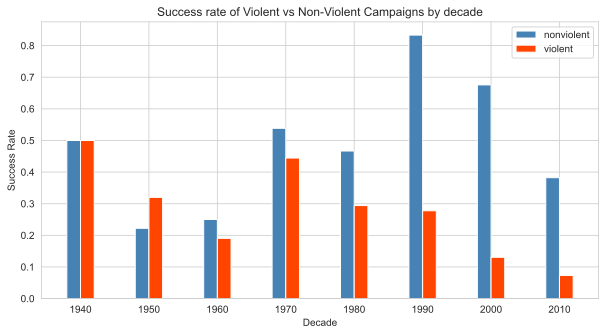

In [70]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 5))

bar_w = 0.2

nonviol_bar_h = nvc_succ_pc_df["NONVIOL_SUCC_PCT"]
viol_bar_h = nvc_succ_pc_df["VIOL_SUCC_PCT"]

# Bar positions
nonviol_pos = np.arange(len(nonviol_bar_h))
viol_pos = [pos + bar_w for pos in nonviol_pos]

# Main plots
plt.bar(
    x=nonviol_pos,
    height=nonviol_bar_h,
    width=bar_w,
    color="steelblue",
    label="nonviolent",
)
plt.bar(x=viol_pos, height=viol_bar_h, width=bar_w, color="orangered", label="violent")

# Labels and Ticks
plt.xlabel("Decade")
plt.ylabel("Success Rate")
plt.xticks([x + bar_w / 2 for x in range(len(viol_bar_h))], list(nvc_succ_pc_df.index))

plt.legend(loc="upper right")

plt.title("Success rate of Violent vs Non-Violent Campaigns by decade")

plt.show()

And once again, we have created a (better, as it has a title) replica of the reference plot. Counterfeit plots are hopefully legal. What do we see?
* Nonviolent campaigns tend to have a much higher success rate, especially in the most recent years.

## 2. Largest Resistance Campaigns, 1946-2014

Create a horizontal bar plot with the resistance campaigns, for all years, with a percentage of participation at least 2.0%. The plot should look like the one below.

Investigate, outside the largest resistance campaigns, if you can find anything about Greece.

<img src='participation_2pct.svg'>

In order to create the plot, we need to use the `navco_df` dataframe.

* First things first; we are looking for at least somewhat popular campaigns. We will filter to keep campaigns with at least `2% participation`.

In [71]:
nvc_two_prc_df = navco_df.loc[navco_df["PERCENTAGEPOPULARPARTICIPATION"] >= 0.02].copy()
nvc_two_prc_df.shape

(32, 24)

* Out of the `389` campaigns, only `32` had over 2% population participation.

* We also need to convert the `PERCENTAGEPOPULARPARTICIPATION` column to the 0-100 scale.

In [72]:
nvc_two_prc_df["PERCENTAGEPOPULARPARTICIPATION"] = round(
    nvc_two_prc_df["PERCENTAGEPOPULARPARTICIPATION"] * 100, 2
)
nvc_two_prc_df["PERCENTAGEPOPULARPARTICIPATION"].sample(5)

NAVCOID
213.0     2.40
169.0     3.41
202.0    19.21
314.0     2.21
183.0     4.65
Name: PERCENTAGEPOPULARPARTICIPATION, dtype: float64

* Now, let's create a composite campaign description column, that consits of the `LOCATION` and `TARGET` columns, formatted nicely.

In [73]:
nvc_two_prc_df.loc[:, "CAMPAIGNDESCR"] = (
    nvc_two_prc_df["LOCATION"] + ": " + nvc_two_prc_df["TARGET"]
)
nvc_two_prc_df["CAMPAIGNDESCR"].sample(5)

NAVCOID
18.0                     Sudan: Jaafar Nimiery
184.0    Yemen Arab Republic: al-Sallal regime
127.0                 Latvia: Communist regime
249.0                     Zambia: British rule
190.0             Lithuania: Lithuanian regime
Name: CAMPAIGNDESCR, dtype: object

* Finally, we would like to sort the campaigns by `PERCENTAGEPOPULARPARTICIPATION` in descending order.

In [74]:
nvc_two_prc_df.sort_values(
    by="PERCENTAGEPOPULARPARTICIPATION", ascending=True, inplace=True
)
nvc_two_prc_df.tail(3)[["CAMPAIGNDESCR", "PERCENTAGEPOPULARPARTICIPATION"]]

,CAMPAIGNDESCR,PERCENTAGEPOPULARPARTICIPATION
NAVCOID,,
249.0,Zambia: British rule,28.51
33.0,Argentina: military junta,30.20
205.0,Slovenia: Yugoslavian rule,45.01


Let's now recreate the plot.

* In order to achieve the color-coding of the bars, we can assign a color to each row by creating a `COLOR` column and assigning `red`, `gray` or `black` depending on whether the campaign was a `FAILURE`, `LIMITED` or `SUCCESS` respectively. 

* We then can use a `for` loop to create each bar, and use `ax.text()` to add the `PERCENTAGEPOPULARPARTICIPATION` information on each bar, as well as do a couple of formatting tricks to make it look nice.

* In order to create the custom legend for the `COLOR` column, we can use `mpatches`, which allows us to create our own legend with custom colors and labels easily.

* Finally, some minor formatting is done to make the plot more presentable.

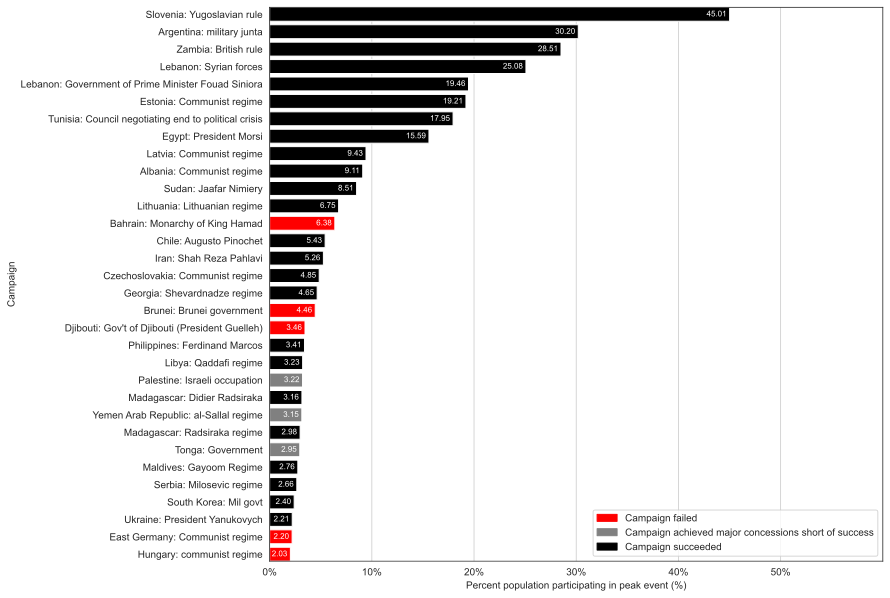

In [75]:
sns.set_style("white", {"axes.grid": False})

fig, ax = plt.subplots(figsize=(11, 10))

# Custom bar colours
conditions = [
    (nvc_two_prc_df["FAILURE"] == 1),
    (nvc_two_prc_df["LIMITED"] == 1),
    (nvc_two_prc_df["SUCCESS"] == 1),
]
colors = ["red", "gray", "black"]
nvc_two_prc_df["COLOR"] = np.select(conditions, colors, default="black")


# Main plots
for i, row in enumerate(nvc_two_prc_df.itertuples()):
    bars = ax.barh(
        row.CAMPAIGNDESCR, row.PERCENTAGEPOPULARPARTICIPATION, color=row.COLOR
    )
    ax.text(
        row.PERCENTAGEPOPULARPARTICIPATION - 0.3,
        i,
        "{:.2f}".format(row.PERCENTAGEPOPULARPARTICIPATION),
        color="white",
        va="center",
        ha="right",
        fontsize=8,
    )

# Custom legend
red_patch = mpatches.Patch(color="red", label="Campaign failed")
gray_patch = mpatches.Patch(
    color="gray", label="Campaign achieved major concessions short of success"
)
black_patch = mpatches.Patch(color="black", label="Campaign succeeded")

ax.legend(handles=[red_patch, gray_patch, black_patch])

# Tick labels and formatting
ax.set_xlabel("Percent population participating in peak event (%)")
ax.set_ylabel("Campaign")

ax.set_xticks(np.arange(0, 60, 10))
ax.set_xticklabels(["{}%".format(x) for x in range(0, 60, 10)])
ax.set_xlim(0, 60)

# Other minor formattings
ax.autoscale(enable=True, axis="y", tight=True)

ax.grid(which="major", axis="x", linestyle="-")

plt.show()

And the plot has been recreated! 

* We can see that, as the bibliography suggestd, there is only `2` exceptions to the `3.5% rule` in our data - specifically the `Brunei` and `Bahrain` campaigns.

* As participation % increases, the amount of `SUCCESS == 1` campaign increases, which makes total sense as more manpower directly leads to a higher success probability.

Now, let's explore what we have available for `Greece`.

In [76]:
nvc_greece_df = navco_df.loc[navco_df["LOCATION"] == "Greece"].copy()
nvc_greece_df

,CAMPAIGN,LOCATION,BYEAR,EYEAR,TARGET,SUCCESS,LIMITED,FAILURE,ONGOING,NONVIOL,...,OTHER,DURATION,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,REGVIOL,DEFECT,VIOLENTFLANK,VIOLSIM,REGAID,STATESUP
NAVCOID,,,,,,,,,,,,,,,,,,,,,
401.0,Greek Civil War,Greece,1946,1949,British and US occupation,0,0,1,0.0,0,...,0.0,1778.0,40000.0,0.005092,1.0,0.0,NaN,0.0,1.0,1.0
89.0,Greek anti-military,Greece,1973,1974,Military rule,1,0,0,0.0,1,...,0.0,654.0,2500.0,0.000279,1.0,1.0,1.0,0.0,1.0,0.0


Our data contains two campaigns that took place in `Greece`:
* The post-WW2 `Greek Civil War` that took place between `1946 - 1949`.
* The `Greek anti-military` campaign against the Regime of the Colonels in `1973-1974`.

Let's take a closer look at some relevant information about these two campaigns.

In [77]:
nvc_greece_df[
    [
        "CAMPAIGN",
        "TARGET",
        "SUCCESS",
        "FAILURE",
        "VIOL",
        "REGCHANGE",
        "PERCENTAGEPOPULARPARTICIPATION",
        "VIOLENTFLANK",
        "VIOLSIM",
        "REGAID",
    ]
]

,CAMPAIGN,TARGET,SUCCESS,FAILURE,VIOL,REGCHANGE,PERCENTAGEPOPULARPARTICIPATION,VIOLENTFLANK,VIOLSIM,REGAID
NAVCOID,,,,,,,,,,
401.0,Greek Civil War,British and US occupation,0,1,1,0.0,0.005092,NaN,0.0,1.0
89.0,Greek anti-military,Military rule,1,0,0,1.0,0.000279,1.0,0.0,1.0


* Both of these campaigns had very low participation in their peak.
    * The `Greek Civil War` mainly took place between the military and communist guerilla militants.
    * The `Greek anti-military` campaign was a student revolution and thus the participation is naturally very low.

* While the participation in the `Greek anti-military` campaign against the Junta is excessively low, it was a great `SUCCESS` that lead to a `REGCHANGE`

* While the `Greek Civil War` was inherently violent, the `Greek anti-military` was not as it was initiated by students. However, we can see that there were violent occurences due to `VIOLENTFLANK` being marked.

* Both campaigns had external military interventions `REGAID`, specifically:
    * In the `Greek Civil War` the official Greek Army received support from allied powers (mainly the US/UK), while the communists were backed by the USSR and Yugoslavia.
    * It generally accepted that the `Greek Military Junta` was supported by the United States.



## 3. The Effect of Participation on the Probability of Campaign Success

### 1) Logistic Regression
Examine the effect of participation on the probability of campaign success. You should run a logistic regression for success on membership per capita, controlling for the location’s logged population the year the campaign ends. Explain your results.


In order to do this task, we have to make use of the `NAVCO 1.1` codebook. 

* According to the author, `membership per capita` or `MEMPC` is calculated as `LMEMBERS/LNPOP`, where:
    * `LMEMBERS` is "*Log of peakmembership*", so the `log()` of `PEAKMEMBERSHIP`, which in `NAVCO 1.2` is `PARTICIPATION`.
    * `LNPOP` is "*Location’s logged population the year the campaign ends, logged*", so `POP` is the of `PARTICIPATION/PERCENTAGEPOPULARPARTICIPATION` as `PERCENTAGEPOPULARPARTICIPATION` is `PARTICIPATION/POPULATION`. We want the `log()` of `POP`.

Let's create these new columns and calculate the `MEMPC` value.

In [78]:
nvc_participation_success_df = navco_df[
    ["CAMPAIGN", "PARTICIPATION", "PERCENTAGEPOPULARPARTICIPATION", "SUCCESS"]
].copy()
nvc_participation_success_df["POP"] = (
    nvc_participation_success_df["PARTICIPATION"]
    / nvc_participation_success_df["PERCENTAGEPOPULARPARTICIPATION"]
)
nvc_participation_success_df["LNPOP"] = np.log2(nvc_participation_success_df["POP"])
nvc_participation_success_df["LMEMBERS"] = np.log2(
    nvc_participation_success_df["PARTICIPATION"]
)
nvc_participation_success_df["MEMPC"] = (
    nvc_participation_success_df["LMEMBERS"] / nvc_participation_success_df["LNPOP"]
)

nvc_participation_success_df.index = navco_df.index

nvc_participation_success_df.sample(5)

,CAMPAIGN,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,SUCCESS,POP,LNPOP,LMEMBERS,MEMPC
NAVCOID,,,,,,,,
61.0,Croats,12500.0,0.001190,1,1.050000e+07,23.323886,13.609640,0.583507
382.0,Peoples’ Alliance for Freedom and Democracy,20000.0,0.000183,0,1.094063e+08,26.705121,14.287712,0.535018
283.0,Anti-Military Government Campaign,13000.0,0.000196,0,6.619562e+07,25.980232,13.666224,0.526024
254.0,Pro-Independence Campaign,NaN,0.000000,0,NaN,NaN,NaN,NaN
71.0,Druze resistance,20000.0,0.005183,0,3.858421e+06,21.879579,14.287712,0.653016


* If we recall from the EDA, some columns have missing values, and more specifically, `PARTICIPATION` does.

* This means a lot of the newly produced columns will also be `NaN`.

* We can handle that either by dropping the `NaN` values, filling them or interpolating them. In this case, I will be dropping them as `PARTICIPATION` is a very important metric as it directly affects `PERCENTAGEPOPULARPARTICIPATION` and thus the newly produced columns. Our findings will be more accurate if we simply drop them.

In [79]:
nvc_participation_success_df.dropna(inplace=True)

Now that our data is ready, let's create our model. 

* We will use `logit` with `SUCCESS` being the dependent variable and `MEMPC`, `LNPOP` being the dependent variables.

* We fit the model and retrieve the summary (specifically `summary2`).

In [80]:
nvc_participation_success_model = logit(
    "SUCCESS ~ MEMPC + LNPOP", data=nvc_participation_success_df
)
nvc_participation_success_res = nvc_participation_success_model.fit()

nvc_participation_success_res.summary2()

Optimization terminated successfully.
         Current function value: 0.580756
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: SUCCESS          Pseudo R-squared: 0.130     
Date:               2023-12-04 20:06 AIC:              447.3747  
No. Observations:   380              BIC:              459.1952  
Df Model:           2                Log-Likelihood:   -220.69   
Df Residuals:       377              LL-Null:          -253.58   
Converged:          1.0000           LLR p-value:      5.1893e-15
No. Iterations:     6.0000           Scale:            1.0000    
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
------------------------------------------------------------------
Intercept      -2.8142    1.4961  -1.8811  0.0600  -5.7465  0.1180
MEMPC           7.6475    1.1664   6.5563  0.0000   5.3613  9.9336
LNPOP          -0.0962    0.0510  -1.8871  0.0591  -0.1962  0.0037
=================================================================

"""

* We can see that McFadden's pseudo-$R^2$ is `0.130`, which means that the fit is not ideal.

* Our `Log-Likelihood` measure is `-220.69`, something we can use to compare with other models with different variables.

* We can see that `MEMPC` significantly increases the probability of success, while the `LNPOP` decreases it slightly.

* The `p-value` of `LNPOP` is slightly higher than `5%`, a common cutoff. Could this parameter be statistically insignificant?

### 2) Scatterplot for Predictions
Having done that, create a scatter plot showing the logged participants per capita, on the $x$ axis, and the probability of success, on the $y$ axis. Your plot should look like the following; explain it as best you can.

<img src="fig_4.svg" />



* In order to get the `Probability of Success` from the plot, we need to use our model to make some predictions.

* We will feed our initial data into the model for the two variables it takes, `MEMPC` and `LNPOP`, and take the predictions it made.

* We essentially try to predict using the data we used to fit the model.

In [81]:
nvc_participation_twovar_predictions_df = nvc_participation_success_res.predict(
    nvc_participation_success_df[["MEMPC", "LNPOP"]]
)
nvc_participation_twovar_predictions_df.sample(2)

NAVCOID
9.0     0.530956
60.0    0.345751
dtype: float64

We can now plot the predictions.

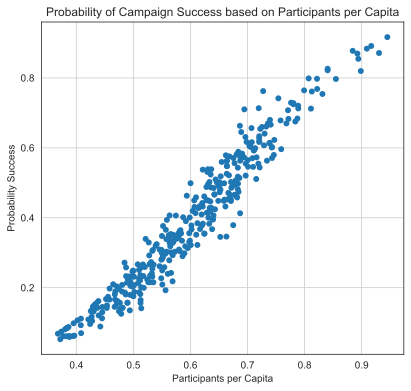

In [82]:
sns.set_style("white", {"axes.grid": True})

plt.figure(figsize=(6.5, 6))
sns.scatterplot(
    x=nvc_participation_success_df["MEMPC"],
    y=nvc_participation_twovar_predictions_df,
    linewidth=0,
)

plt.xlabel("Participants per Capita")
plt.ylabel("Probability Success")
plt.title("Probability of Campaign Success based on Participants per Capita")

plt.show()

* We can see, that just like the `coeff` suggested, the probability of success significantly increases as the participants per capita increase.

### 3) A different approach
Then, do the same but with only the membership per capital as dependent variable. Your plot should look like this (explain why is this different than the previous one):

<img src="fig_5.svg" />

We will now train our model using one variable, `MEMPC`.

In [83]:
nvc_one_prc_mod = logit("SUCCESS ~ MEMPC", data=nvc_participation_success_df)
nvc_one_prc_res = nvc_one_prc_mod.fit()

nvc_one_prc_res.summary2()

Optimization terminated successfully.
         Current function value: 0.585556
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: SUCCESS          Pseudo R-squared: 0.123     
Date:               2023-12-04 20:06 AIC:              449.0222  
No. Observations:   380              BIC:              456.9026  
Df Model:           1                Log-Likelihood:   -222.51   
Df Residuals:       378              LL-Null:          -253.58   
Converged:          1.0000           LLR p-value:      3.2041e-15
No. Iterations:     6.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -5.3469    0.7095  -7.5362  0.0000  -6.7375  -3.9563
MEMPC          8.0495    1.1414   7.0524  0.0000   5.8125  10.2866
=================================================================

"""

* We can see that the pseudo-$R^2$ is `0.123`, slightly lower than before.

* `Log-Likelihood` has remained almost identical.

* Our variables are confidently statistically significant.

In [84]:
nvc_participation_onevar_predictions_df = nvc_one_prc_res.predict(
    nvc_participation_success_df[["MEMPC"]]
)
nvc_participation_onevar_predictions_df.sample(2)

NAVCOID
347.0    0.229449
379.0    0.103848
dtype: float64

Let's plot once again...

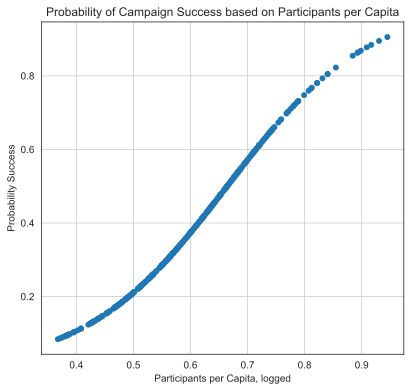

In [85]:
sns.set_style("white", {"axes.grid": True})

plt.figure(figsize=(6.5, 6))
sns.scatterplot(
    x=nvc_participation_success_df["MEMPC"],
    y=nvc_participation_onevar_predictions_df,
    linewidth=0,
)

plt.xlabel("Participants per Capita, logged")
plt.ylabel("Probability Success")
plt.title("Probability of Campaign Success based on Participants per Capita")

plt.show()

* This plot is different, it looks like the `sigmoid` function.

* That's because since our model is univariate, and we measure probability, the predictions fall exactly on the probability line and they are not affected/deviated by a second variable.

## 4. The Level of Participation Tipping Point

As we mentioned above, a famous output of the research is the 3.5% rule regarding the population participation in a campaign and the probability of success.

Based on your data, create a table like the one below and explain how Chenoweth came up with the rule.

<table>
<thead>
<tr><th>Peak Popular Participation (%)  </th><th style="text-align: right;">  Observations</th><th>Success Rate  </th></tr>
</thead>
<tbody>
<tr><td>greater than 3.5%               </td><td style="text-align: right;">            18</td><td>88.89%        </td></tr>
<tr><td>1.0% - 3.5%                     </td><td style="text-align: right;">            41</td><td>60.98%        </td></tr>
<tr><td>0.25% - 1.0%                    </td><td style="text-align: right;">            92</td><td>45.65%        </td></tr>
<tr><td>0.06% - 0.25%                   </td><td style="text-align: right;">            95</td><td>45.26%        </td></tr>
<tr><td>0.015% - 0.06%                  </td><td style="text-align: right;">            66</td><td>24.24%        </td></tr>
<tr><td>0.0035% - 0.015%                </td><td style="text-align: right;">            44</td><td>9.09%         </td></tr>
<tr><td>less than 0.0035%               </td><td style="text-align: right;">            24</td><td>4.17%         </td></tr>
</tbody>
</table>

* It is clear that Chenoweth placed the data in bins, using the category `Peak Popular Participation (%)`. We can do the same by creating the same bins with custom labels and the `pd.cut()` function.

* She uses the 0-100 scale for measuring success rate, so we have to multiply our `PERCENTAGEPOPULARPARTICIPATION` column by 100 to produce the same results.

* We then group by the bins and count the amount of `CAMPAIGN`'s per bin, so the `Observations`, as well as the amount of successful campaigns so we can produce the `Success Rate` later on.

In [86]:
bins = [0, 0.0035, 0.015, 0.06, 0.25, 1.0, 3.5, 100]
labels = [
    "less than 0.0035%",
    "0.0035% - 0.015%",
    "0.015% - 0.06%",
    "0.06% - 0.25%",
    "0.25% - 1.0%",
    "1.0% - 3.5%",
    "greater than 3.5%",
]

nvc_binned_df = navco_df[
    ["CAMPAIGN", "PERCENTAGEPOPULARPARTICIPATION", "SUCCESS"]
].copy()
nvc_binned_df["PERCENTAGEPOPULARPARTICIPATION"] = (
    nvc_binned_df["PERCENTAGEPOPULARPARTICIPATION"] * 100
)

nvc_binned_df["BIN"] = pd.cut(
    nvc_binned_df["PERCENTAGEPOPULARPARTICIPATION"], bins=bins, labels=labels
)

nvc_chenoweth_df = nvc_binned_df.groupby(nvc_binned_df["BIN"]).agg(
    {"SUCCESS": "sum", "CAMPAIGN": "count"}
)
nvc_chenoweth_df

,SUCCESS,CAMPAIGN
BIN,,
less than 0.0035%,1,24
0.0035% - 0.015%,4,44
0.015% - 0.06%,16,66
0.06% - 0.25%,43,95
0.25% - 1.0%,42,92
1.0% - 3.5%,25,41
greater than 3.5%,16,18


* Now, let's produce the `SUCCESSRATE` column, and round to `2` decimal digits like Chenoweth did.

* We also sort the bins in a descending order to match the table given to us.

In [87]:
nvc_chenoweth_df["SUCCESSRATE"] = round(
    (nvc_chenoweth_df["SUCCESS"] / nvc_chenoweth_df["CAMPAIGN"]) * 100, 2
)
nvc_chenoweth_df.sort_values(by="BIN", ascending=False)

,SUCCESS,CAMPAIGN,SUCCESSRATE
BIN,,,
greater than 3.5%,16,18,88.89
1.0% - 3.5%,25,41,60.98
0.25% - 1.0%,42,92,45.65
0.06% - 0.25%,43,95,45.26
0.015% - 0.06%,16,66,24.24
0.0035% - 0.015%,4,44,9.09
less than 0.0035%,1,24,4.17


Finally, we rename the columns so as to achieve a perfect match.

In [88]:
nvc_chenoweth_df.reset_index(inplace=True)
nvc_chenoweth_df.drop("SUCCESS", axis=1, inplace=True)
nvc_chenoweth_df.rename(
    columns={
        "BIN": "Peak Popular Participation (%)",
        "CAMPAIGN": "Observations",
        "SUCCESSRATE": "Success Rate",
    },
    inplace=True,
)

And voila...

In [89]:
HTML(nvc_chenoweth_df.to_html(index=False))

Peak Popular Participation (%),Observations,Success Rate
less than 0.0035%,24,4.17
0.0035% - 0.015%,44,9.09
0.015% - 0.06%,66,24.24
0.06% - 0.25%,95,45.26
0.25% - 1.0%,92,45.65
1.0% - 3.5%,41,60.98
greater than 3.5%,18,88.89


Apart from the way Chenoweth came up with the rule, we can derive it in more statistically-based way.  From the results you obtained in the previous question, find the percentage of the population that is the tipping point for success in a campaign with 99% probability.

To replicate Chenoweth's result in a more statistically-based way, we could use the lower and upper bounds of the confidence intervals for `MEMPC`, until the probability of `SUCCESS` is the lowest value equal or larger than `99` - the `tipping point`, and then we can get the `PERCENTAGEPOPULARPARTICIPATION`.

In [90]:
nvc_one_prc_res_conf_int_df = nvc_one_prc_res.conf_int()
nvc_one_prc_res_conf_int_df

,0,1
Intercept,-6.737471,-3.956310
MEMPC,5.812452,10.286588


* Let's make them a bit more readable.

In [91]:
nvc_one_prc_res_conf_int_df.rename(columns={0: "MIN", 1: "MAX"}, inplace=True)
nvc_one_prc_res_conf_int_df = nvc_one_prc_res_conf_int_df.transpose()

min_intercept_int, max_intercept_int = nvc_one_prc_res_conf_int_df["Intercept"]
min_mempc_int, max_mempc_int = nvc_one_prc_res_conf_int_df["MEMPC"]

nvc_one_prc_res_conf_int_df

,Intercept,MEMPC
MIN,-6.737471,5.812452
MAX,-3.956310,10.286588


Now, to plot;

* We should define the `sigmoid` function we will use so as to get the probability of success values for our analysis, as well as the intermediate results and plots.

In [92]:
def sigmoid(x, a, b):
    return 1 / (1 + np.exp(-(a * x + b)))

* We can also generate some x-values to create a continuous sigmoid function for our plot.

In [93]:
mempc_values_cont = np.linspace(
    nvc_participation_success_df["MEMPC"].min(),
    nvc_participation_success_df["MEMPC"].max(),
    1000,
)

* We should also generate, for this data, the maximum and minimum confidence interval lines, as it will help us pinpoint the tipping point.

In [94]:
max_conf_int_line = sigmoid(mempc_values_cont, max_mempc_int, max_intercept_int)
min_conf_int_line = sigmoid(mempc_values_cont, min_mempc_int, min_intercept_int)

Now, let's visualize:

* We will draw a line for the maximum probability, `1.0`.

* We will draw a red dashed lined for the desired probability, `0.99`. 

* We will plot our `mempc_values_cont` sigmoid.

* We will plot the max, min confidence interval lines we generated using `conf_int()` and the sigmoid.
    * We also fill between these lines and our main plot, so we have a clear range.

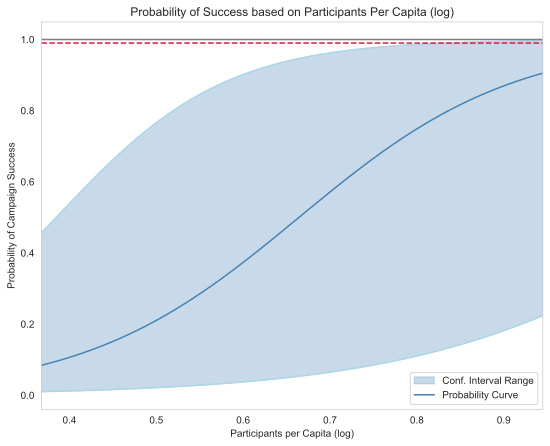

In [95]:
sns.set_style("whitegrid", {"axes.grid": False})

plt.figure(figsize=(9, 7))

# Confidence Interval Range
plt.plot(mempc_values_cont, max_conf_int_line, linestyle="-", color="lightblue")
plt.plot(mempc_values_cont, min_conf_int_line, linestyle="-", color="lightblue")

plt.fill_between(
    mempc_values_cont,
    min_conf_int_line,
    max_conf_int_line,
    color="steelblue",
    alpha=0.3,
    label="Conf. Interval Range",
)

# Staple Lines
plt.axhline(y=1.0, color="gray", linestyle="-")
plt.axhline(y=0.99, color="crimson", linestyle="--")

# Main Plot
prob_succ_df = sigmoid(
    mempc_values_cont,
    nvc_one_prc_res.params["MEMPC"],
    nvc_one_prc_res.params["Intercept"],
)
plt.plot(
    mempc_values_cont,
    prob_succ_df,
    color="steelblue",
    linestyle="-",
    label="Probability Curve",
)

# Details
plt.xlabel("Participants per Capita (log)")
plt.ylabel("Probability of Campaign Success")
plt.title("Probability of Success based on Participants Per Capita (log)")

plt.legend(loc="lower right")
plt.margins(x=0, y=0.05)

plt.show()

This is a very refreshing plot, and very useful.

* We see that our confidence interval range intercepts the `0.99` probability line, just a bit after `MEMPC` is `0.80`. 

* So, it is possible to have campaigns with `0.99` probability of success or higher.

Let's now find the `MEMPC` value that will give us the tipping now.

* We want the index of the first value that is `>= 99%`, so we can use `argmax()`.

In [96]:
mempc_lim = mempc_values_cont[np.argmax(max_conf_int_line >= 0.99)]
mempc_lim

0.8317264701641368

Now, let's find the first value about the `MEMPC` limit from our data.

* We will filter using the `mempc_lim`, sort in an ascending order and get the head. This will give us the first entry that is above the 99% success probability cutoff, according to `MEMPC`.

In [97]:
success_99_values_df = nvc_participation_success_df.loc[
    nvc_participation_success_df["MEMPC"] >= mempc_lim
].copy()

tipping_point = success_99_values_df.sort_values(
    by="PERCENTAGEPOPULARPARTICIPATION"
).head(1)
tipping_point

,CAMPAIGN,PARTICIPATION,PERCENTAGEPOPULARPARTICIPATION,SUCCESS,POP,LNPOP,LMEMBERS,MEMPC
NAVCOID,,,,,,,,
18.0,anti-Jaafar,2000000.0,0.085106,1,23500000.0,24.486157,20.931569,0.854833


* We can see that the `anti-Jaafar` campaign is the tipping point campaign entry.

* The tipping point of `PERCENTAGEPOPULARPARTICIPATION` value being `0.085` or `8.5%`, which is significantly higher than Chenoweth's findings show.

* Chenoweth, however, found that the `3.5%` rule applied for a `success rate` of `88.89%`, as we previously saw in the board. We were a bit stricter.


## 5. Nonviolent Resistance and Target Regime Type

Examine whether nonviolent resistance remains significant even if we control for the regime type. Run a logistic   regression of success on the nonviolence indicator controlling for the Polity V score of campaign target, the log of participation, and the location’s logged population the year the campaign ends.


For this problem, we need to merge our two datasets; `navco` and `polity5_df`, so as to create the desired model.

* Since we need `LNPOP`, we have already calculated that and we can use the `nvc_participation_success_df` dataframe.

* We can do this on the country and the end year, specifically:
    * For `nvc_participation_success_df`, `LOCATION` and `EYEAR`.
    * For `polity5_df`, `COUNTRY` and `YEAR`.

* We will do a `left` merge as we want to simply attach the `polity5` data on our `NAVCO 1.2` data. 

In [98]:
nvc_merged_df = pd.merge(nvc_participation_success_df, navco_df, how="left")
nvc_polity_merged_df = pd.merge(
    nvc_merged_df,
    polity5_df,
    how="left",
    left_on=["LOCATION", "EYEAR"],
    right_on=["country", "year"],
)
nvc_polity_merged_df.rename(columns={"polity": "POLITY"}, inplace=True)
nvc_polity_merged_df.shape

(380, 65)

* We also need the `log()` of `PARTICIPATION`, the `LPART`!

In [99]:
nvc_polity_merged_df["LPART"] = np.log2(nvc_polity_merged_df["PARTICIPATION"])

* And that means we have all the variables we need for our model.

In [100]:
nvc_merged_relevant_df = nvc_polity_merged_df[
    ["CAMPAIGN", "SUCCESS", "NONVIOL", "POLITY", "LPART", "LNPOP"]
].copy()

nvc_merged_relevant_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CAMPAIGN  380 non-null    object 
 1   SUCCESS   380 non-null    int64  
 2   NONVIOL   380 non-null    int64  
 3   POLITY    305 non-null    float64
 4   LPART     380 non-null    float64
 5   LNPOP     380 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 17.9+ KB


* We can see that the `POLITY` score is missing for some campaigns.

* We will once again drop these values, as it would be impossible to guesstimate the `POLITY` score.

In [101]:
nvc_merged_relevant_df.dropna(how="any", inplace=True)

We can now build our model;

* `SUCCESS` will be the dependent variable.

* `POLITY`, `NONVIOL`, `LPART` and `LNPOP` will be our independent variables.

In [102]:
nvc_merged_mod = logit(
    "SUCCESS ~ NONVIOL + POLITY + LPART + LNPOP", data=nvc_merged_relevant_df
)
nvc_merged_res = nvc_merged_mod.fit()

nvc_merged_res.summary2()

Optimization terminated successfully.
         Current function value: 0.542765
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: SUCCESS          Pseudo R-squared: 0.194     
Date:               2023-12-04 20:06 AIC:              341.0868  
No. Observations:   305              BIC:              359.6883  
Df Model:           4                Log-Likelihood:   -165.54   
Df Residuals:       300              LL-Null:          -205.27   
Converged:          1.0000           LLR p-value:      2.2774e-16
No. Iterations:     6.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept      1.2494    1.5079   0.8286  0.4073  -1.7060   4.2049
NONVIOL        0.9251    0.2868   3.2253  0.0013   0.3629   1.4873
POLITY        -0.0094    0.0040  -2.3393  0.0193  -0.0173  -0.0015
LPART          0.2950    0.0605   4.8738  0.0000   0.1764   0.4137
LNPOP         -0.2732    0.0685  -3.9895  0.0001  -0.4074  -0.1390
=================================================================

"""

* We can see that that `NONVIOL` is statistically significant, as are all of the variables in our model.

* The  pseudo-$R^2$ value is approaching values that are promising for the model, however not there yet (0.2-0.4).

* `NONVIOL`'s coefficient shows us that non-violent campaigns have a significant positive impact on the probability of `SUCCESS`. Sometimes words are stronger than bullets.

* `POLITY` does not affect the predictions too much.

* The logged population on the end year of the campaign has a negative impact on the success probability, while the logged participation has a positive impact.

## Honor Code

You understand that this is an individual assignment, and as such you must carry it out alone. You may seek help on the Internet, on ChatGPT, Bard, or Bing, by Googling or searching in StackOverflow for general questions pertaining to the use of Python and pandas libraries and idioms. However, it is not right to ask direct questions that relate to the assignment and where people will actually solve your problem by answering them. You may discuss with your fellow students in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.